In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce ETV Result for KIC 4909707

- also known as TIC 121119758

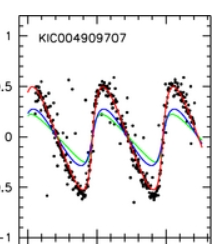

(x, time-span: ~1300 d ; y, O-C in kilosecs)

Source:  `2013ApJ...768...33R` [Triple-star Candidates among the Kepler Binaries](https://ui.adsabs.harvard.edu/abs/2013ApJ...768...33R/abstract) 


In [3]:
# define the plotting parameters

figsize = (8,4)

In [23]:
# import the data

# choose a TIC ID to analyze
ticid = 121119758
kicid = 4909707  # ETV amplitude ~1000sec / 16min
# reference: 2013ApJ
# 
# TODO: consider to include Kepler data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u



# sr = lk.search_lightcurve('KIC{}'.format(kicid))
# sr = sr[sr.exptime == 1800 * u.s]  # exclude 1 quarter that has both 30min and 1min cadence data
# sr = lke._sort_chronologically(sr)
# display(sr)
# lcc_kplr = sr.download_all()
# lc_kplr = lcc_kplr[:].stitch()
# lc_kplr.time.format = "mjd"  # to be consistent with the paper result, also for ease of combining with TESS data
# lc_kplr = lc_kplr.truncate(None, 55800)  # longer test with ~1 ETV cycle based on reference plot

sr = lk.search_lightcurve('TIC {}'.format(ticid), author="SPOC")  # all available TESS sectors has short cadence data
# sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
# sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
lc_tess.time.format = "mjd"

search_result = lk.LightCurveCollection([
    # lc_kplr,
    lc_tess,
]).stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance  proposal_id 
                                  s                 arcsec               
--- -------------- ---- ------ ------- ----------- -------- -------------
  0 TESS Sector 14 2019   SPOC     120   121119758      0.0       G022062
  1 TESS Sector 40 2021   SPOC     120   121119758      0.0 G04171_G04234
  2 TESS Sector 41 2021   SPOC     120   121119758      0.0 G04171_G04234
  3 TESS Sector 53 2022   SPOC     120   121119758      0.0 G04171_G04234
  4 TESS Sector 54 2022   SPOC     120   121119758      0.0 G04171_G04234

91562

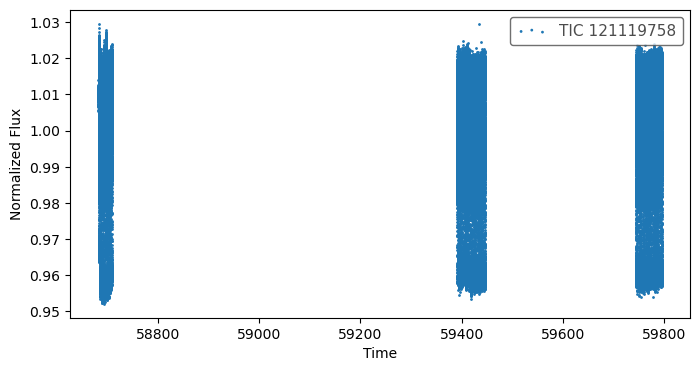

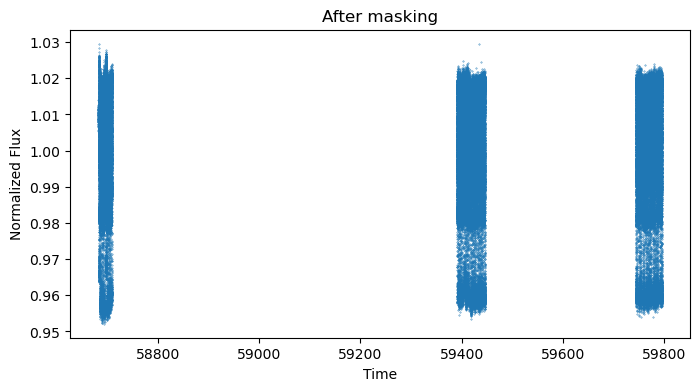

In [25]:
%matplotlib inline
# %matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)


mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

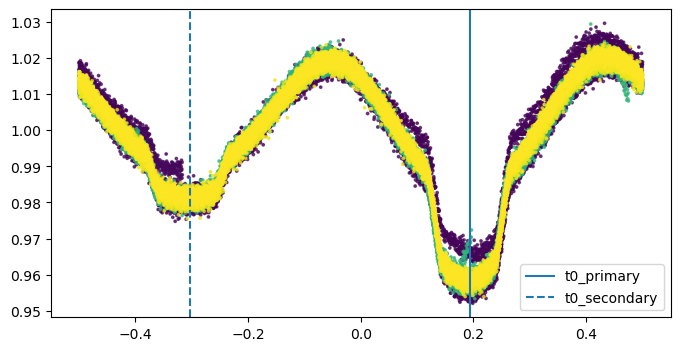

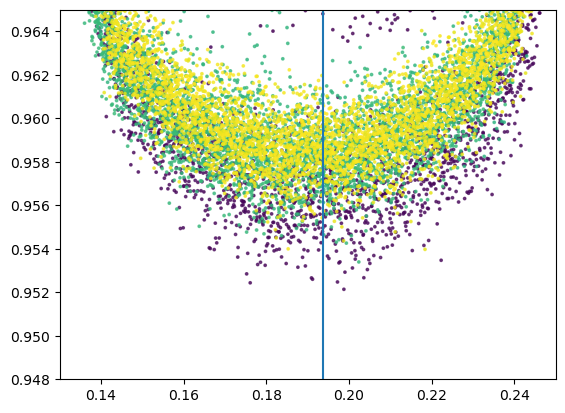

In [26]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# period = 2.3023637  # Kepler EB Period
period = 2.302370  # 2013ApJ Period


t0_primary = 54953.913193 - 0.5  # Kepler EB, the MJD there seems to be off by 0.5
t0_secondary = t0_primary + period * 0.5028


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 0.1440 * period * 24  # used for the window to cut the lighcurve around eclipses in later cells
duration_hr_secondary = 0.2721 * period * 24  

t0_for_plotting = 0  # keep 0 for plotting purposes
# t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.25  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(0.13, 0.25);
plt.ylim(0.948, 0.965);
plt.show()

### Now that the data is ready we can start 

In [27]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0      58682.856675  1.011480  0.001563  0.021767
1      58682.858064  1.011356  0.001566  0.022370
2      58682.859453  1.012189  0.001560  0.022973
3      58682.860842  1.011297  0.001563  0.023577
4      58682.862231  1.010221  0.001562  0.024180
...             ...       ...       ...       ...
91245  59795.625545  1.005233  0.001086  0.336295
91246  59795.626934  1.004573  0.001086  0.336898
91247  59795.628323  1.007600  0.001087  0.337501
91248  59795.629712  1.006329  0.001087  0.338104
91249  59795.631100  1.006552  0.001087  0.338708

[91250 rows x 4 columns]

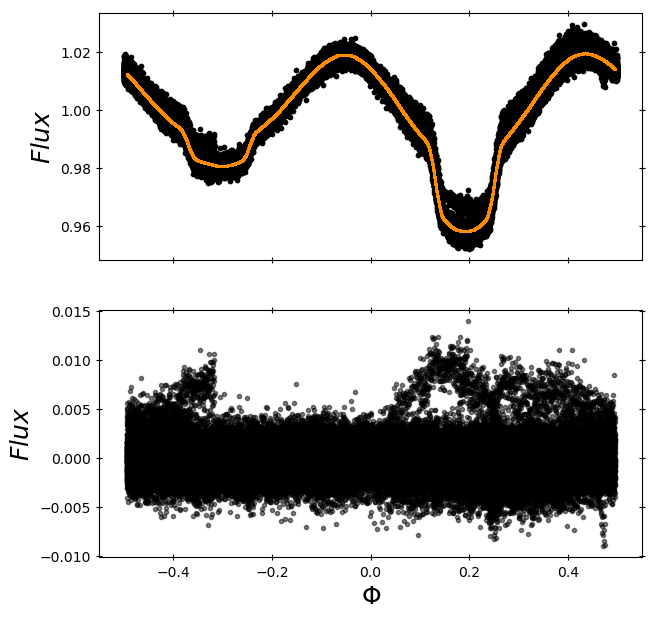

time      flux       err     phase  flux_sub_binary  \
0      58682.856675  1.011480  0.001563  0.021767         0.001621   
1      58682.858064  1.011356  0.001566  0.022370         0.001617   
2      58682.859453  1.012189  0.001560  0.022973         0.002570   
3      58682.860842  1.011297  0.001563  0.023577         0.001799   
4      58682.862231  1.010221  0.001562  0.024180         0.000846   
...             ...       ...       ...       ...              ...   
91245  59795.625545  1.005233  0.001086  0.336295         0.000522   
91246  59795.626934  1.004573  0.001086  0.336898        -0.000284   
91247  59795.628323  1.007600  0.001087  0.337501         0.002599   
91248  59795.629712  1.006329  0.001087  0.338104         0.001183   
91249  59795.631100  1.006552  0.001087  0.338708         0.001262   

       binary_model  
0          1.009859  
1          1.009740  
2          1.009620  
3          1.009498  
4          1.009375  
...             ...  
91245      1.004711  
91246      1.004856  
91247      1.005001  
91248      1.005146  
91249      1.005290  

[91250 rows x 6 columns]

In [28]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 90354 901
reached the end
10 89644 901
reached the end
10 89525 901
reached the end
10 89488 901
reached the end
10 89477 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      58682.856675  1.011480  0.001563  0.021767         0.001621   
1      58682.858064  1.011356  0.001566  0.022370         0.001617   
2      58682.859453  1.012189  0.001560  0.022973         0.002570   
3      58682.860842  1.011297  0.001563  0.023577         0.001799   
4      58682.862231  1.010221  0.001562  0.024180         0.000846   
...             ...       ...       ...       ...              ...   
91245  59795.625545  1.005233  0.001086  0.336295         0.000522   
91246  59795.626934  1.004573  0.001086  0.336898        -0.000284   
91247  59795.628323  1.007600  0.001087  0.337501         0.002599   
91248  59795.629712  1.006329  0.001087  0.338104         0.001183   
91249  59795.631100  1.006552  0.001087  0.338708         0.001262   

       binary_model  flux_detrended  
0          1.009859        1.009455  
1          1.009740        1.009280  
2          1.009620        1.010062  
3          1.009498        1.009122  
4          1.009375        1.007996  
...             ...             ...  
91245      1.004711        1.004727  
91246      1.004856        1.004068  
91247      1.005001        1.007097  
91248      1.005146        1.005827  
91249      1.005290        1.006052  

[91250 rows x 7 columns]

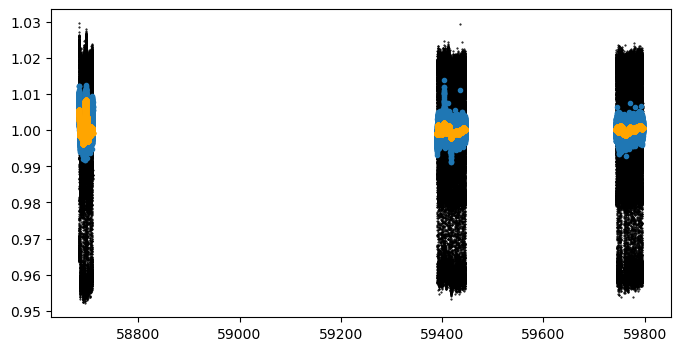

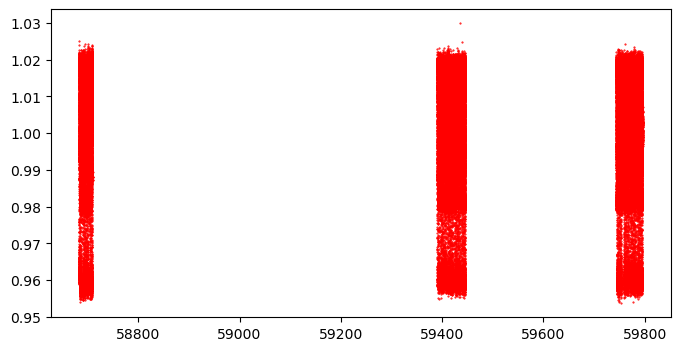

In [29]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

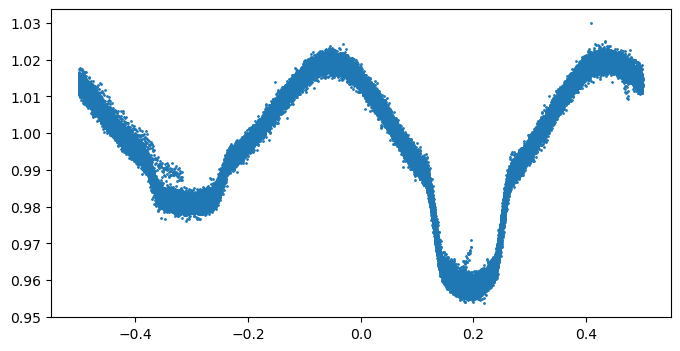

In [30]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   58680.950223 0.19372776747539966
window_width_p (phase): 0.07343999999999999
Secondary: 58682.107854636 -0.3034722325243451
window_width_s (phase): 0.0802695


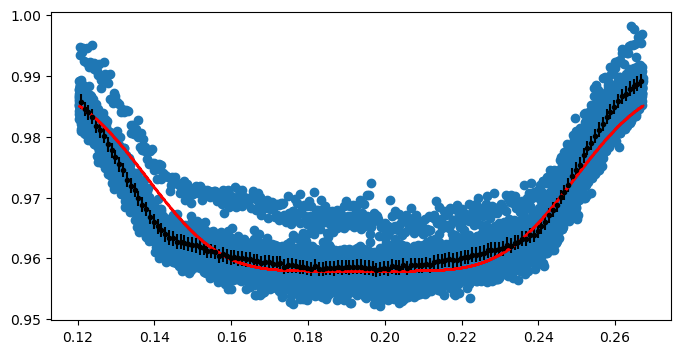

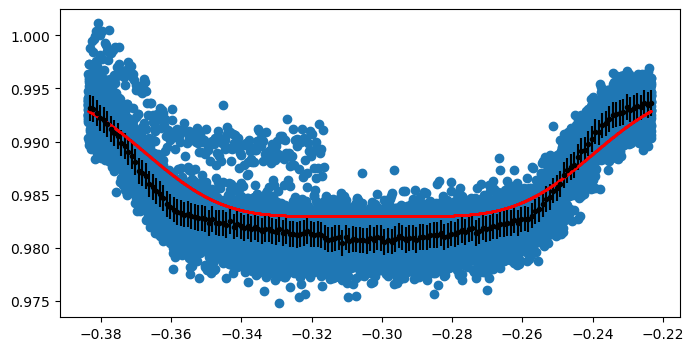

In [31]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.51 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    window_width_s = 0.295 * duration_hr_secondary / 24 / period
    # window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [0.989, -0.031, midpoint_p, 0.035, 3]
start_vals_s = [0.995, -0.012, midpoint_s, 0.04, 3]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

100%|██████████████████████████████████████████████████████████| 1000/1000 [04:41<00:00,  3.56it/s]


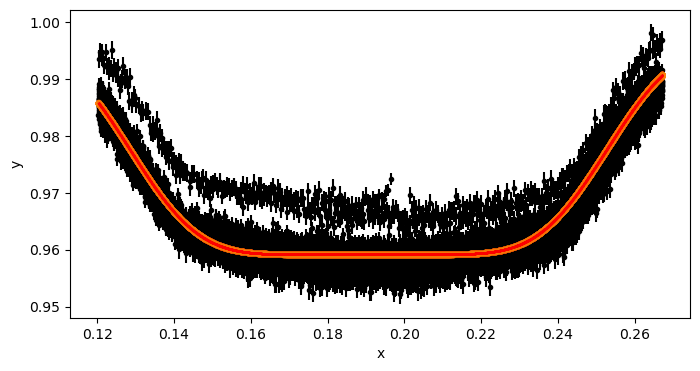

100%|██████████████████████████████████████████████████████████| 1000/1000 [04:51<00:00,  3.43it/s]


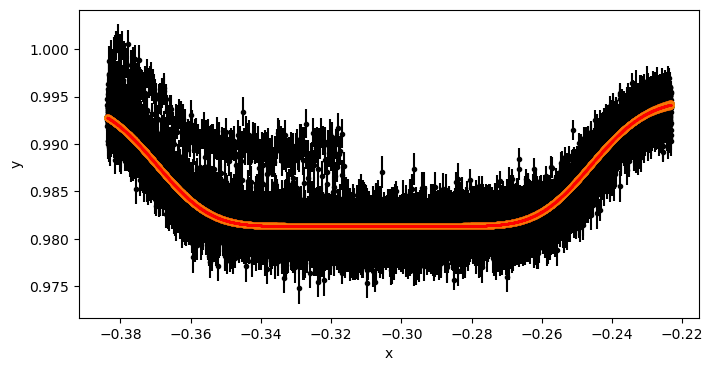

In [32]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [33]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # # initial fit params from Kepler data (<MJD 55300) + 2013Apj Period
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0067056199183277, -0.04968806376987012, 0.1932242174827597, 0.04302157128042646, 2.749792096496858
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9959214608053015, -0.013597789783198196, -0.30513366658463253, 0.040778592196784785, 3.07492557755622

    # initial fit params from Kepler data (<MJD 55800) + 2013Apj Period
    # It doesn't fit too well (especially Tau and d ,which won't be fitted individaully) when TESS data is included, but we'll use it for now
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.006027094542627, -0.04918382258148684, 0.1932828485615261, 0.042863943156954576, 2.7485029533481917
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9958208880831946, -0.013381598530201908, -0.30494860531805923, 0.04014324677947079, 3.1984068892498416

    # initial fit params from TESS data + 2013Apj Period
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9969371090426153, -0.03775014081268692, 0.19059299138270203, 0.036428352549633114, 4.154702444759279
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9946783503313517, -0.013320028481656317, -0.3078815391328813, 0.03424277243616522, 5.6849377994585275

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [34]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9969371090426153, -0.03775014081268692, 0.19059299138270203, 0.036428352549633114, 4.154702444759279
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9946783503313517, -0.013320028481656317, -0.3078815391328813, 0.03424277243616522, 5.6849377994585275


483

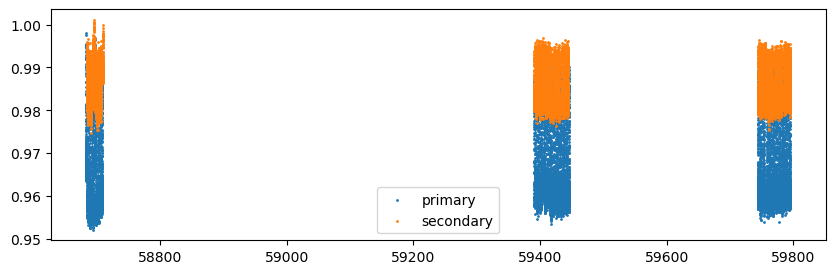

In [35]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

58680.950223 2.30237 58680.950223


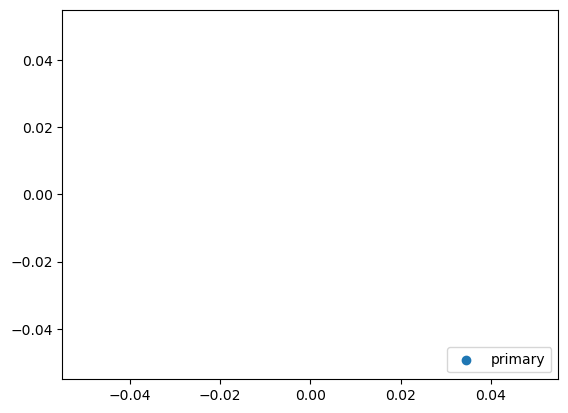

58680.950223 2.30237 58683.252593


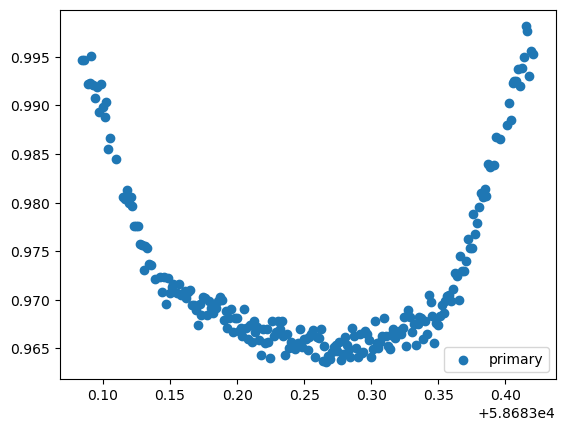

58680.950223 2.30237 58685.554963


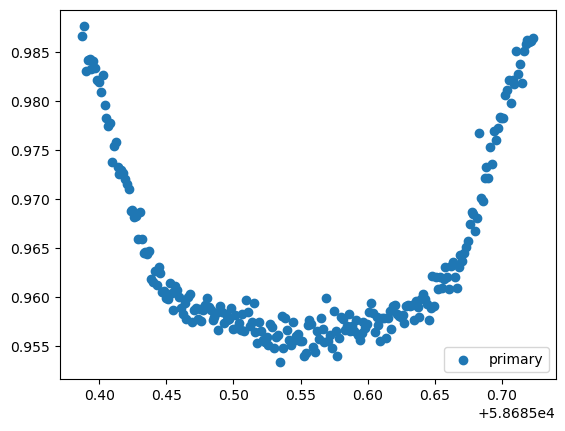

58682.107854636 2.30237 58682.107854636


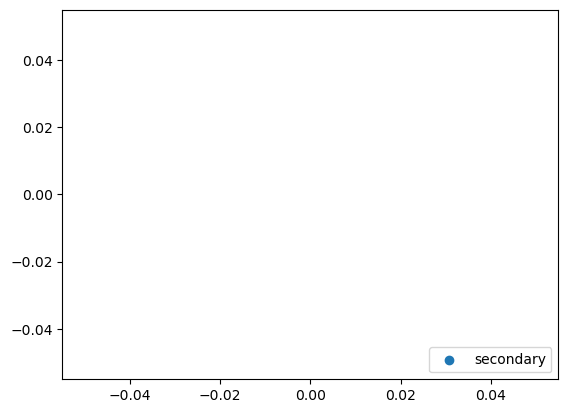

58682.107854636 2.30237 58684.410224636


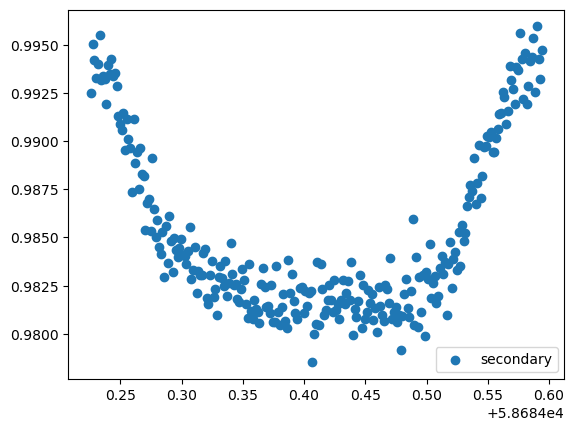

58682.107854636 2.30237 58686.712594636


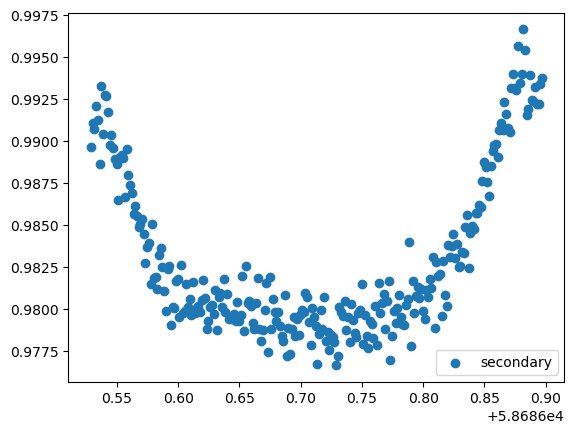

In [36]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 308 has already been completed -- skip
Number 309 has already been completed -- skip
Number 310 has already been completed -- skip
Number 311 has already been completed -- skip
Number 312 has already been completed -- skip
Number 313 has already been completed -- skip
Number 314 has already been completed -- skip
Number 3

100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.90it/s]


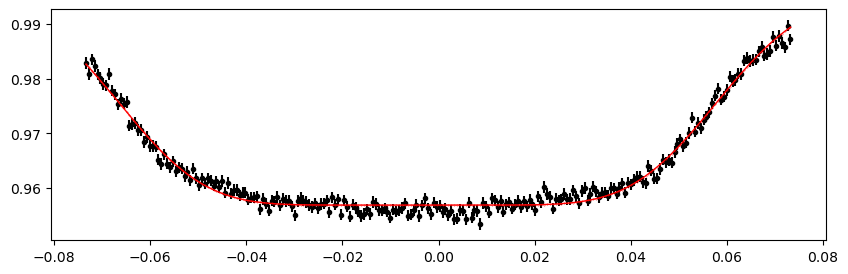

59420.010992999996 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.46it/s]


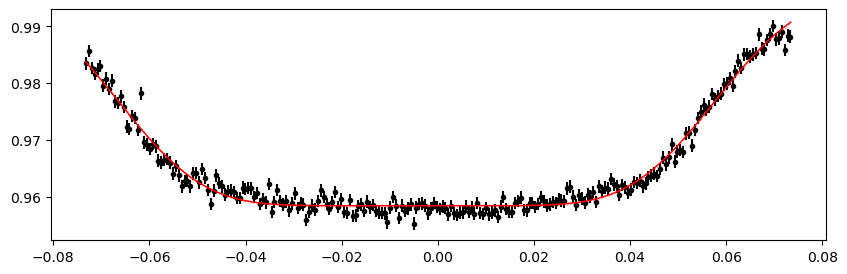

59422.313363 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.72it/s]


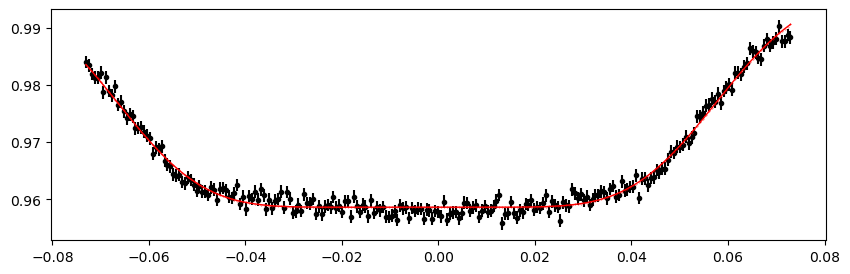

59424.615733 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.57it/s]


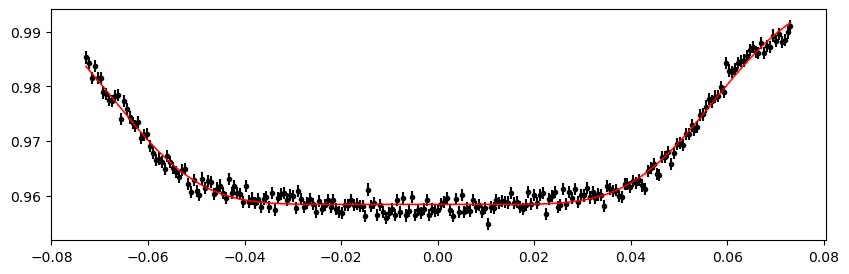

59426.918102999996 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.15it/s]


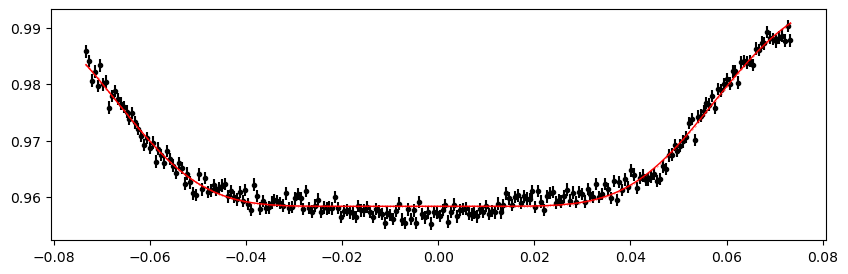

59429.220473 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.84it/s]


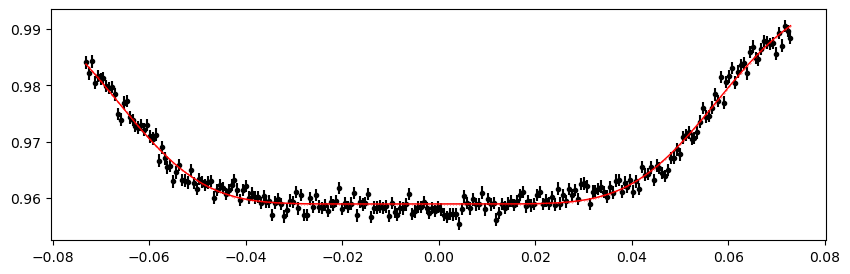

59431.522843 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.05it/s]


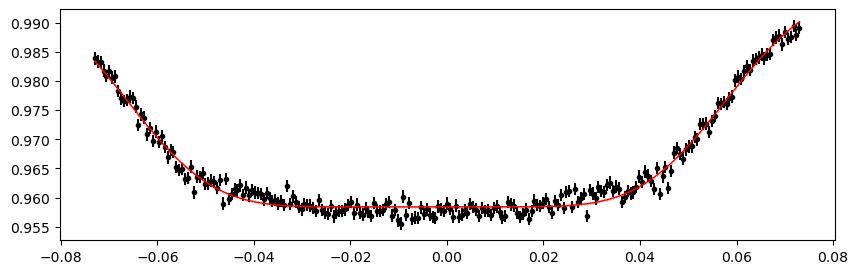

59433.825213 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.29it/s]


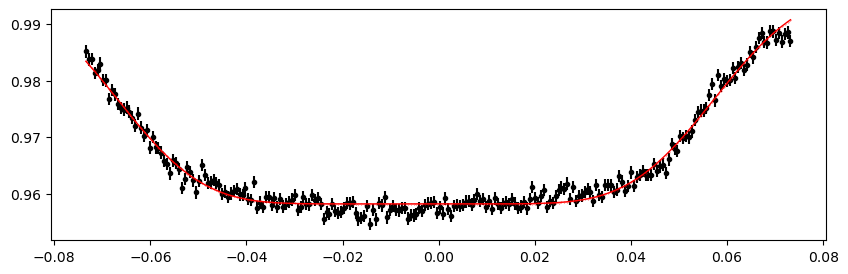

59436.127583 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.95it/s]


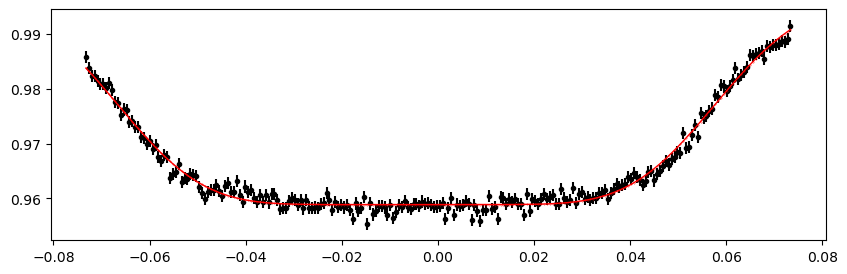

59438.429953 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.60it/s]


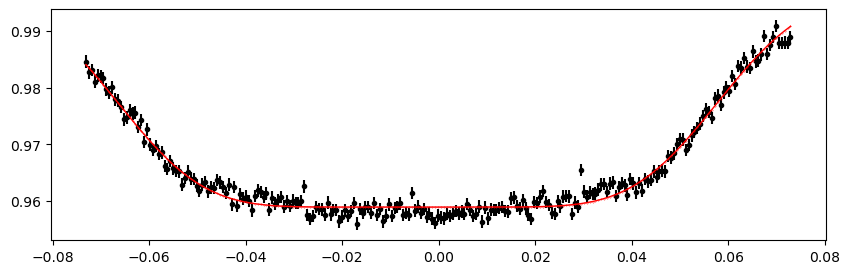

59440.732323 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.56it/s]


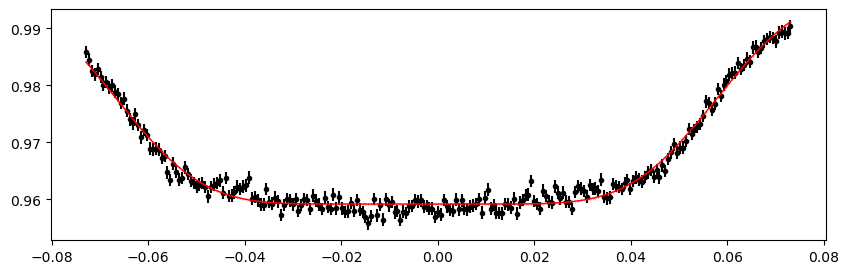

59443.034693 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.54it/s]


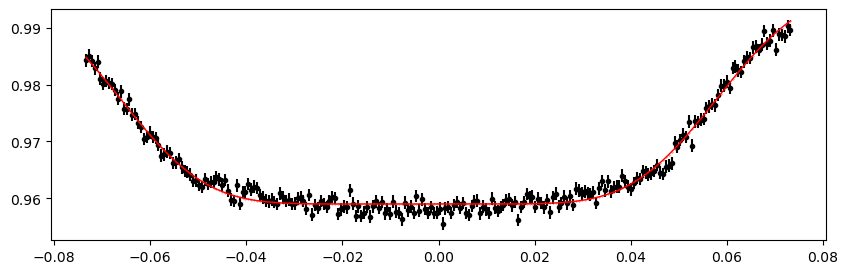

59445.337063 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.71it/s]


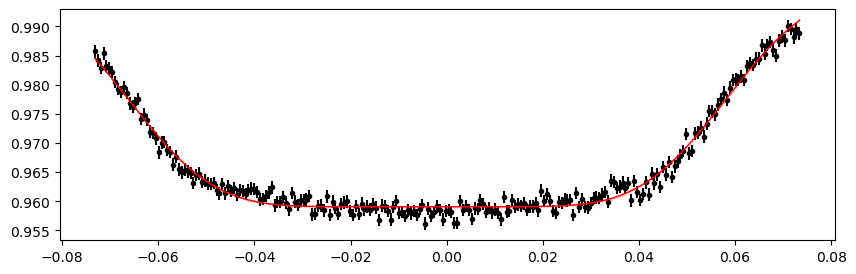

59744.645163 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.87it/s]


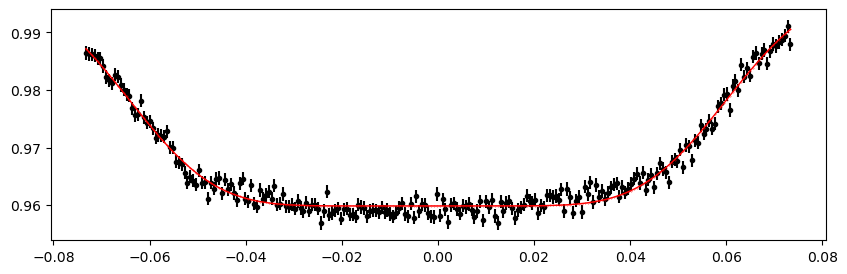

59746.947533 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.77it/s]


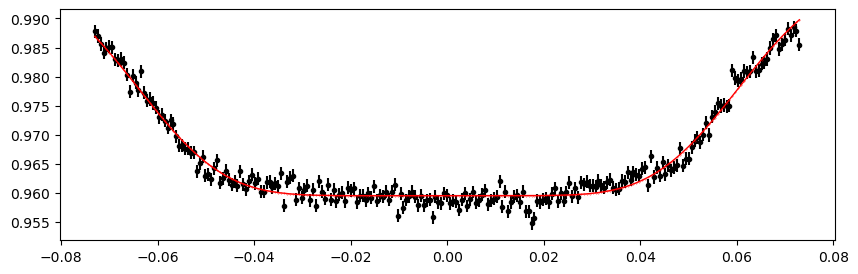

59749.249902999996 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.71it/s]


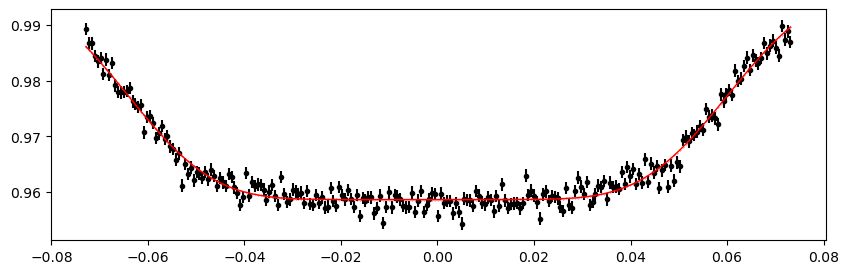

59751.552273 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.39it/s]


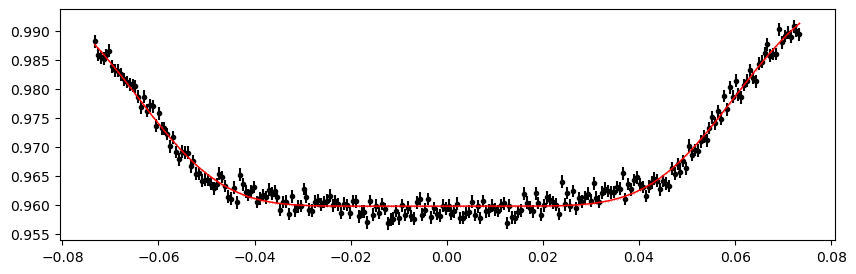

59753.854643 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.08it/s]


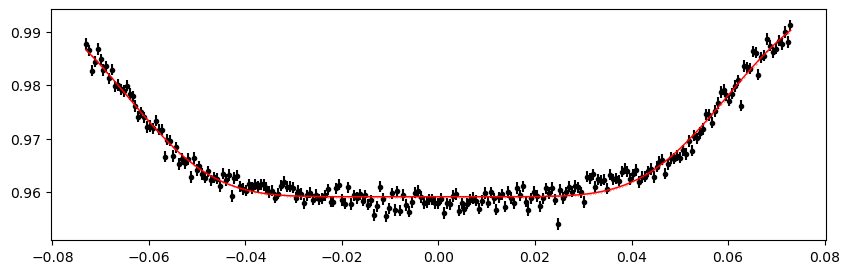

59758.459383 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.57it/s]


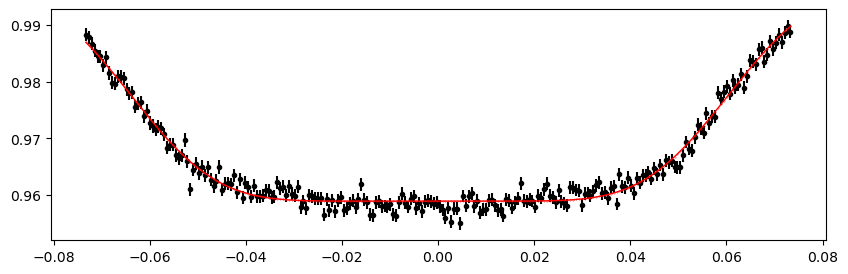

59760.761753 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.18it/s]


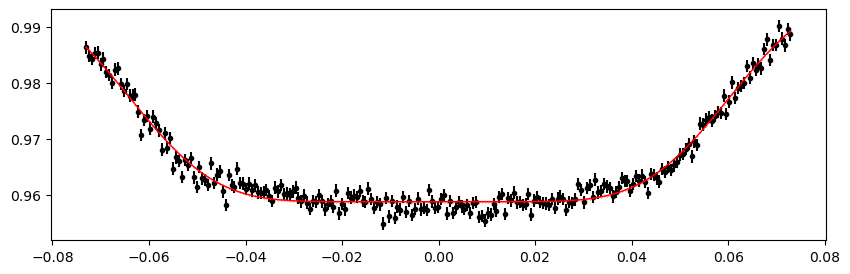

59763.064123 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.02it/s]


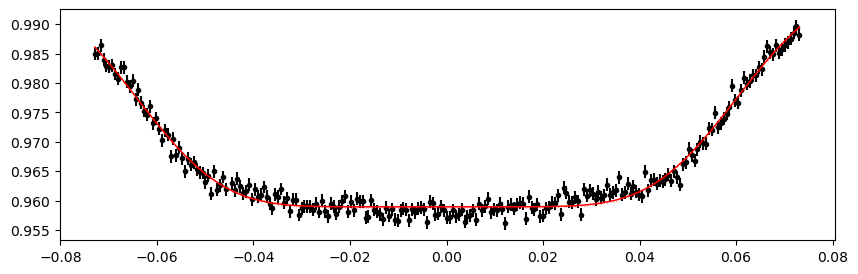

59765.366493 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.15it/s]


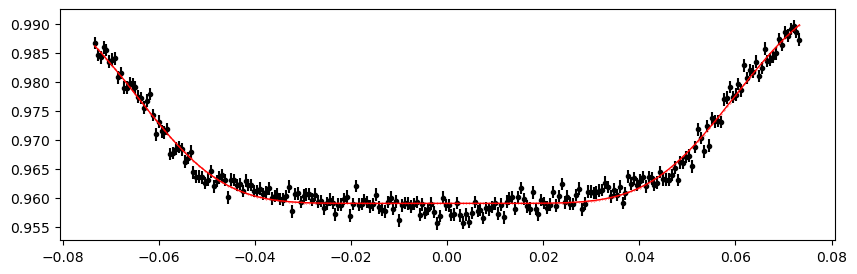

59767.668863 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.30it/s]


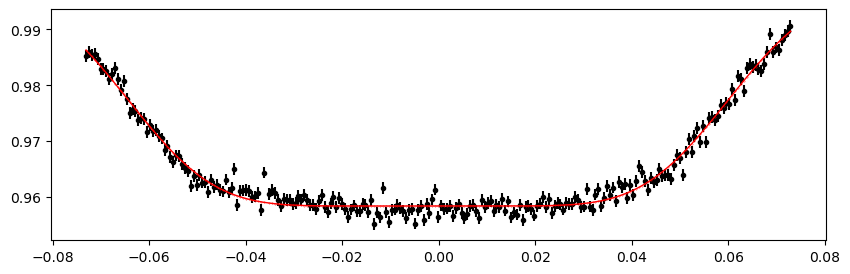

59769.971233 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.75it/s]


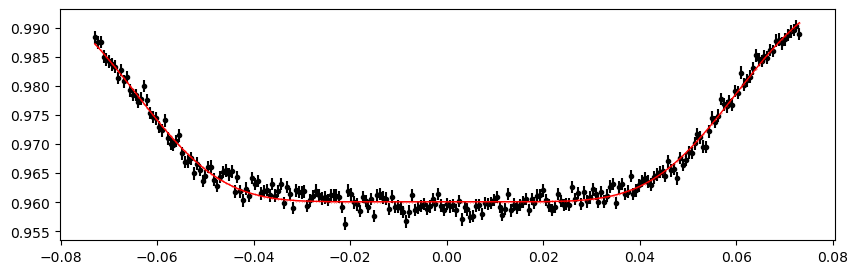

59772.273603 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.97it/s]


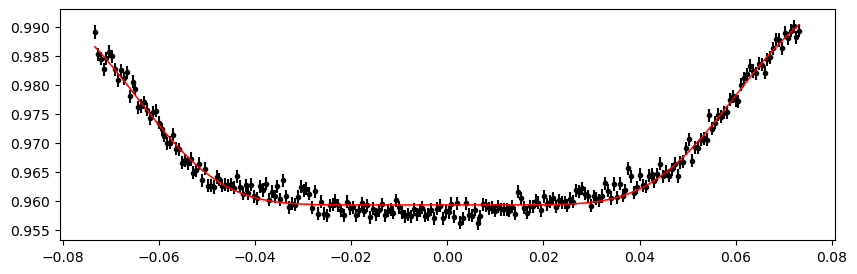

59774.575973 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.73it/s]


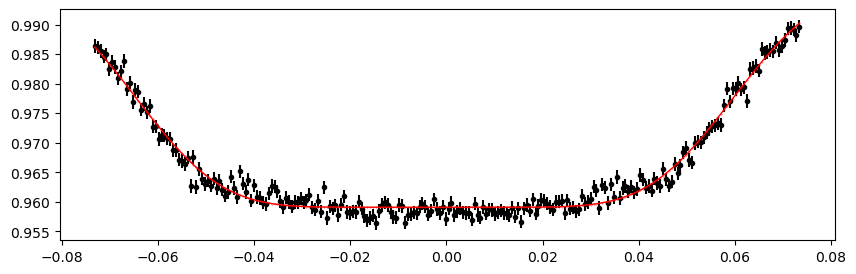

59776.878343 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.97it/s]


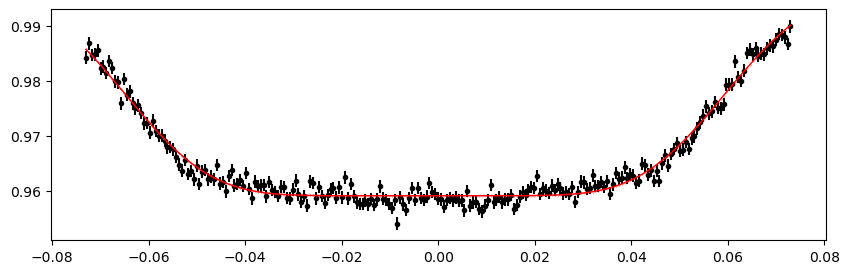

59779.180713 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 285.21it/s]


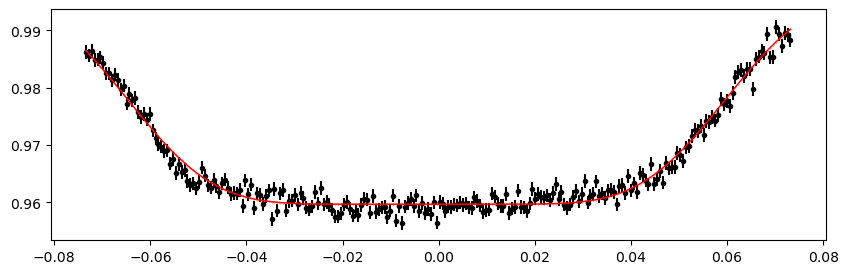

59781.483083 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.91it/s]


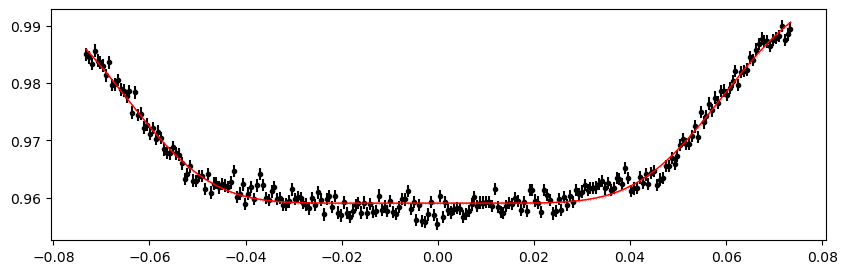

59783.785453 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.47it/s]


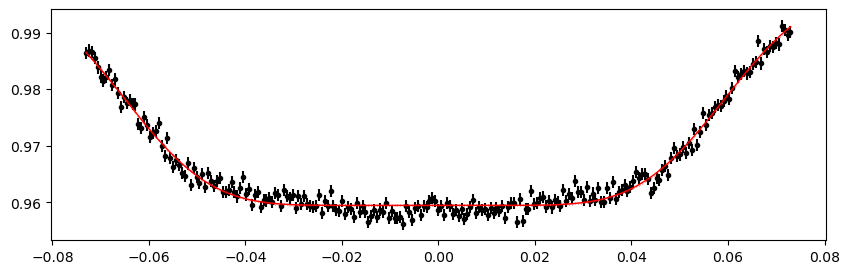

59786.087823 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.53it/s]


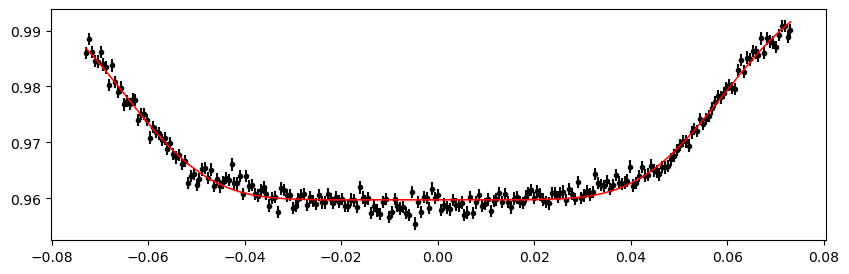

59788.390193 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.53it/s]


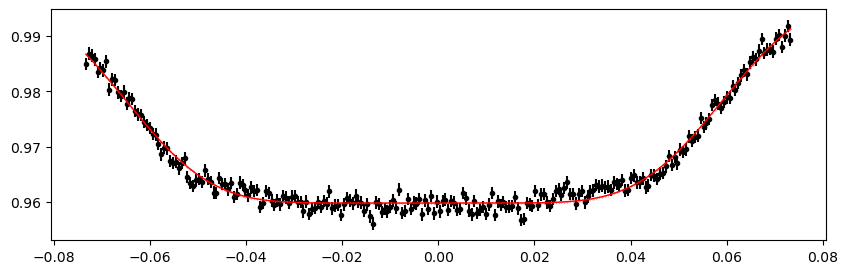

59790.692563 0.9969371090426153 -0.03775014081268692 0.19059299138270203


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.24it/s]


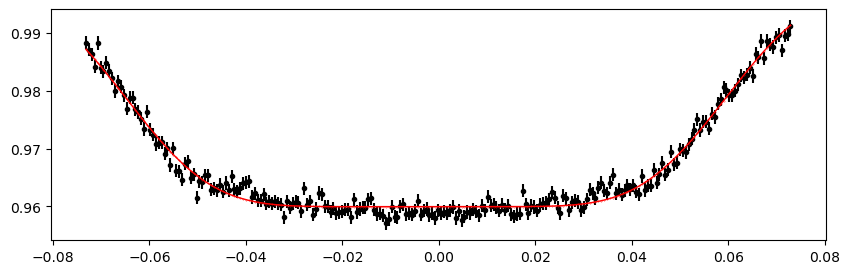

Fitting individual secondary eclipses...
Creating new manifest file
58684.410224636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.05it/s]


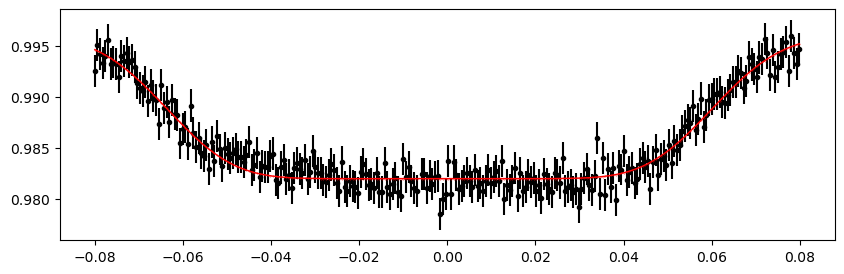

58686.712594636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.84it/s]


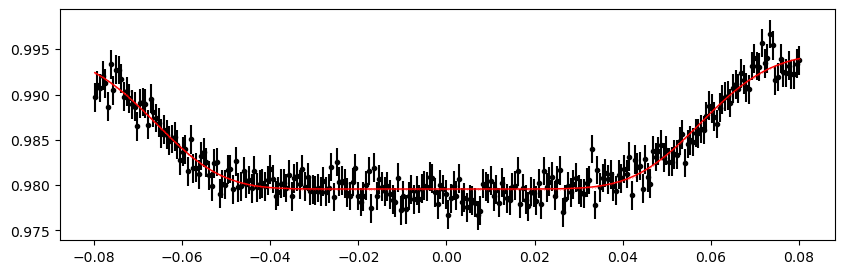

58689.014964636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.05it/s]


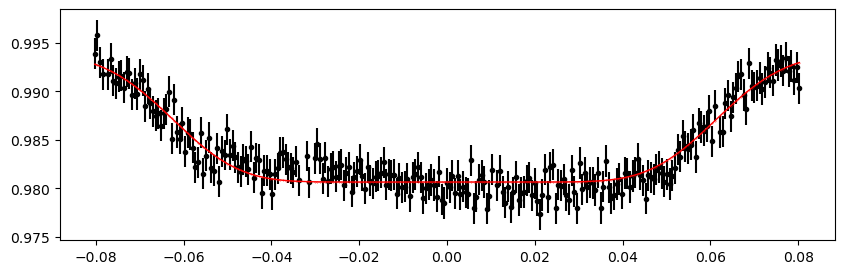

58691.317334636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.35it/s]


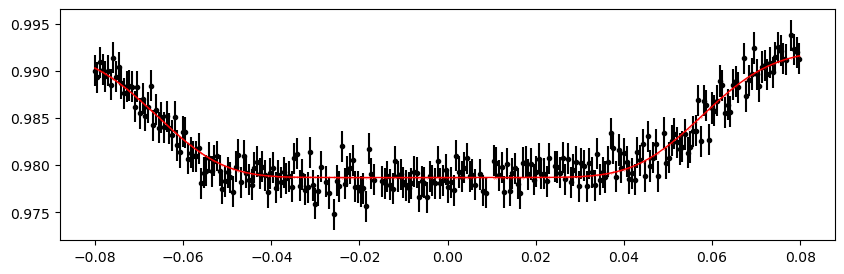

58693.619704636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 282.16it/s]


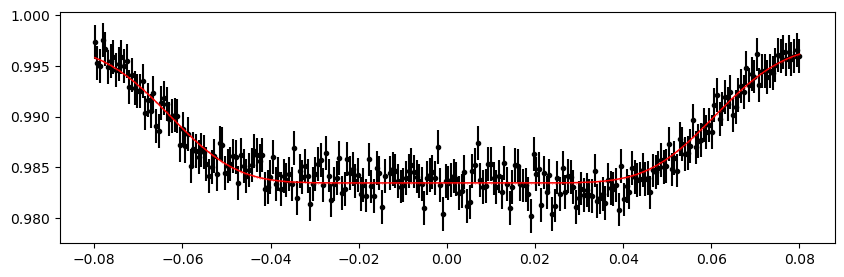

58695.922074636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.13it/s]


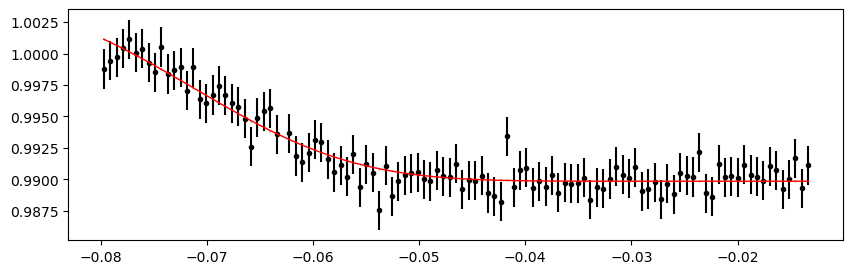

58698.224444636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.07it/s]


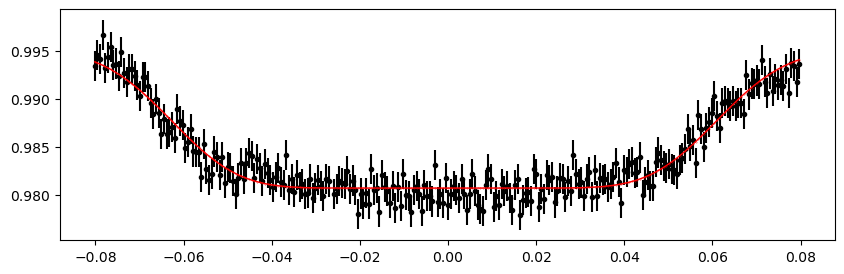

58700.526814636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.48it/s]


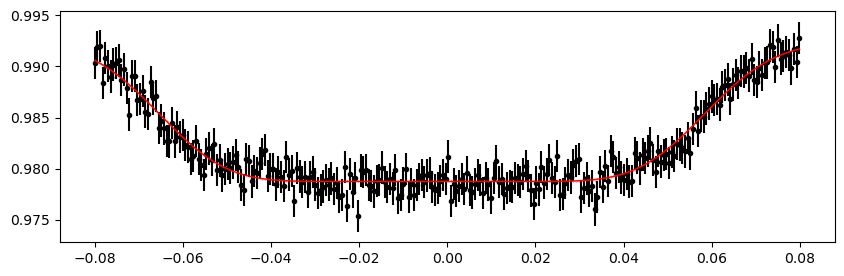

58702.829184636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.62it/s]


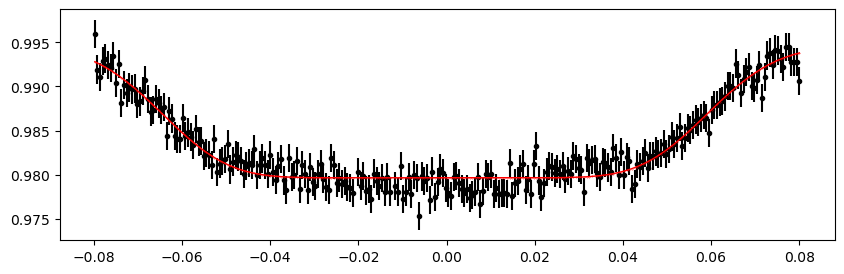

58705.131554636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.57it/s]


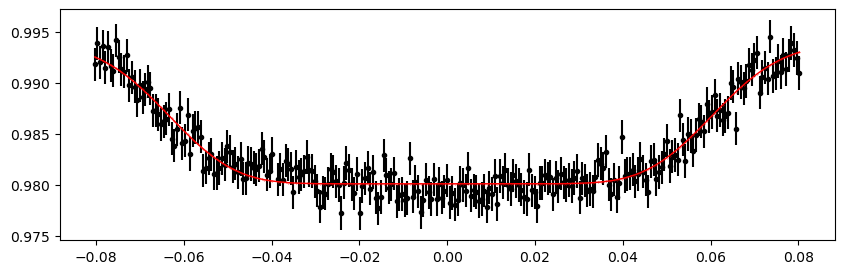

58707.433924636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.80it/s]


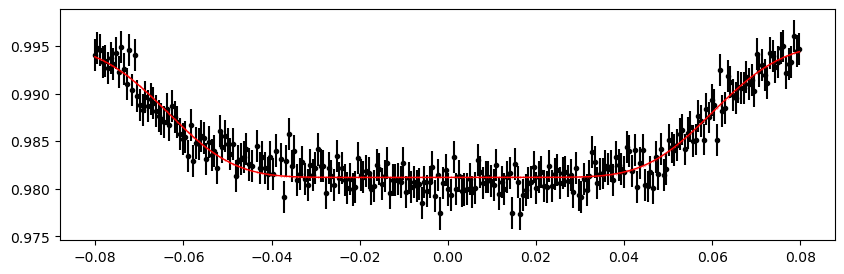

58709.736294636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.62it/s]


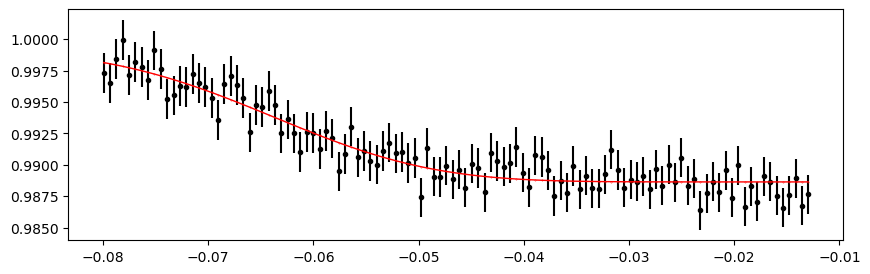

59391.237814636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.37it/s]


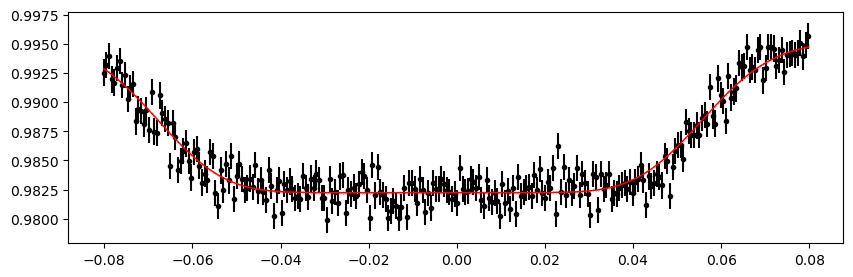

59393.540184636004 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.07it/s]


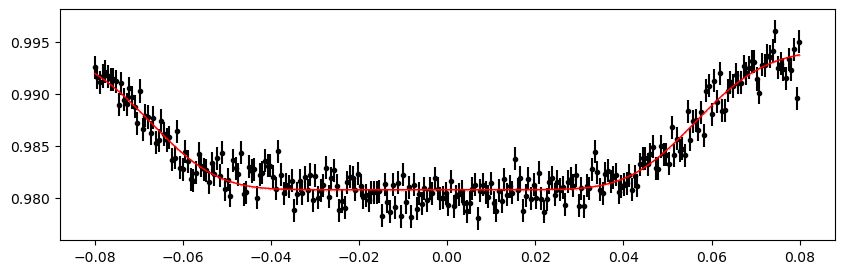

59395.842554636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 280.71it/s]


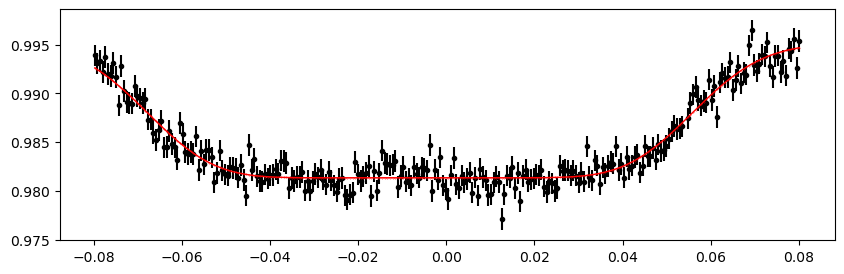

59398.144924636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.09it/s]


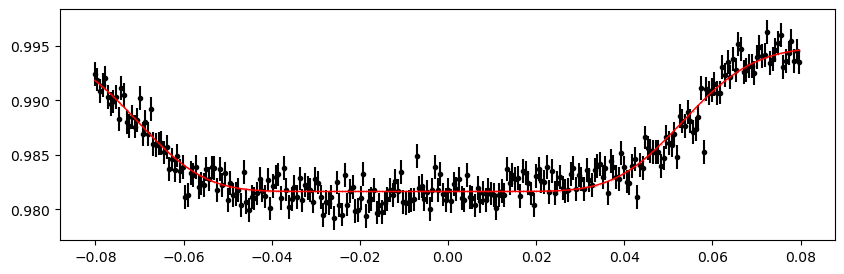

59400.447294636004 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.22it/s]


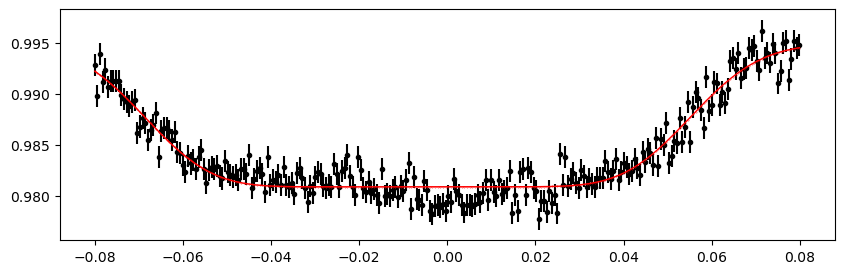

59402.749664636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.36it/s]


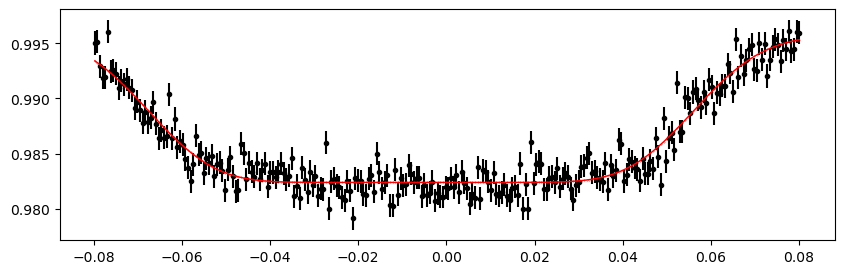

59405.052034636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.26it/s]


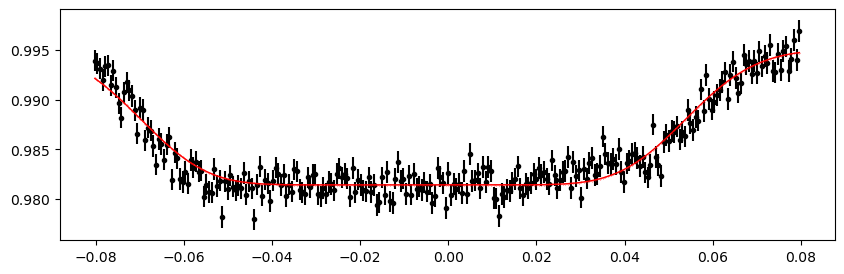

59407.354404636004 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.43it/s]


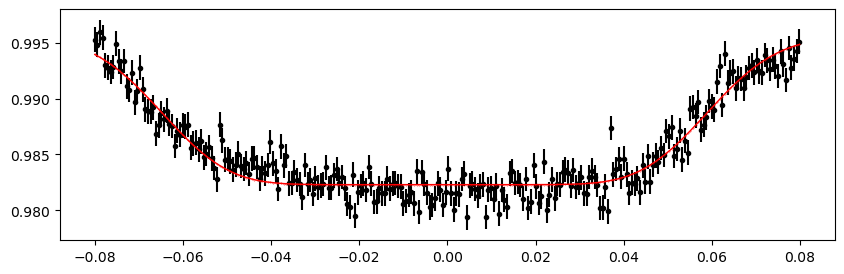

59409.656774636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.36it/s]


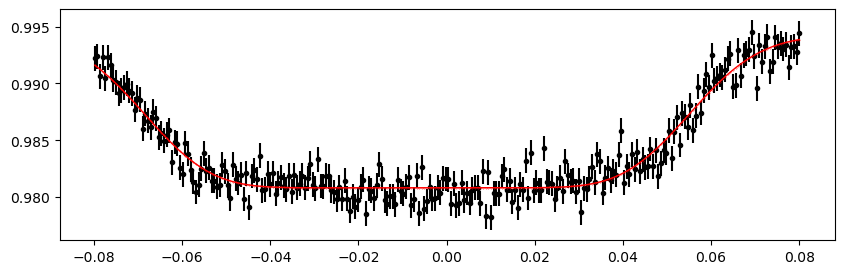

59411.959144636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.39it/s]


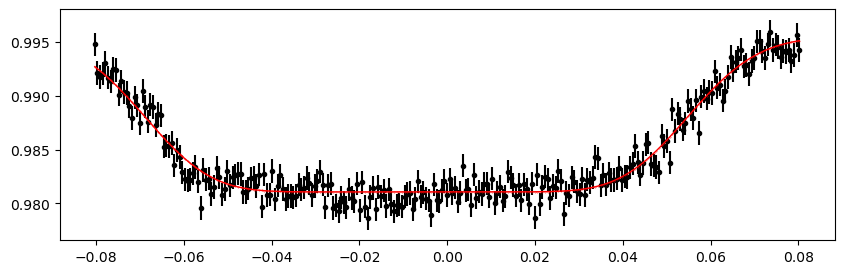

59414.261514636004 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.69it/s]


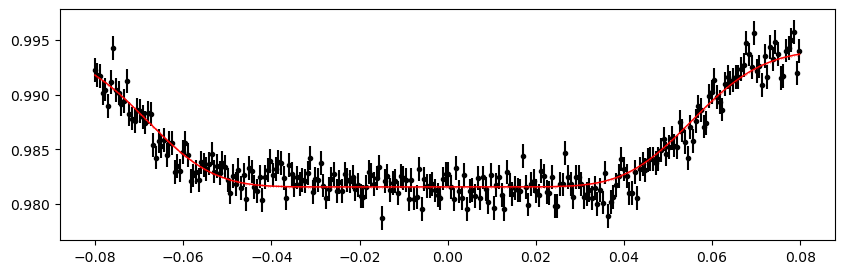

59416.563884636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 302.58it/s]


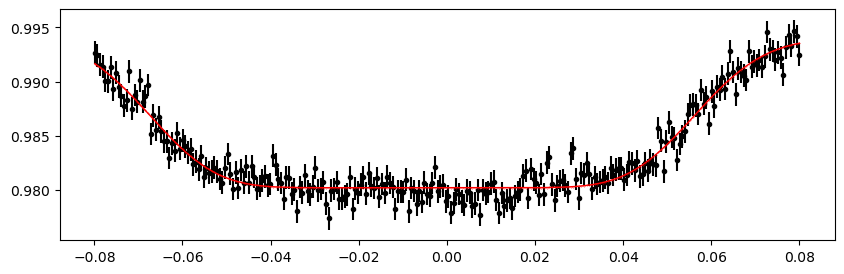

59421.168624636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.66it/s]


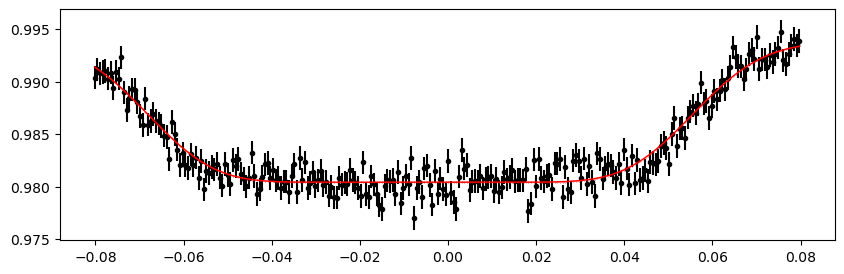

59423.470994636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.91it/s]


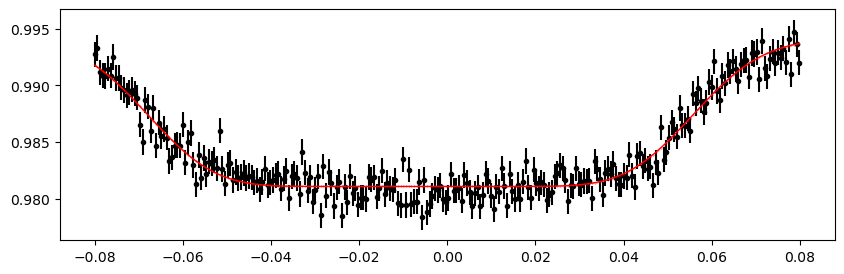

59425.773364636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.92it/s]


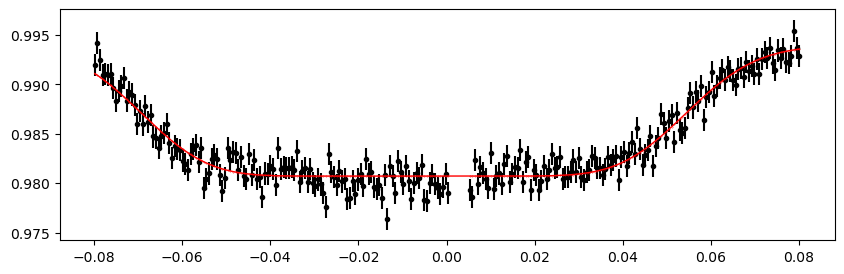

59428.075734636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.38it/s]


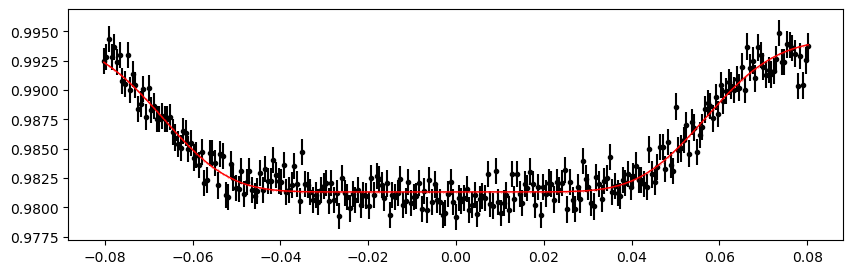

59430.378104636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.89it/s]


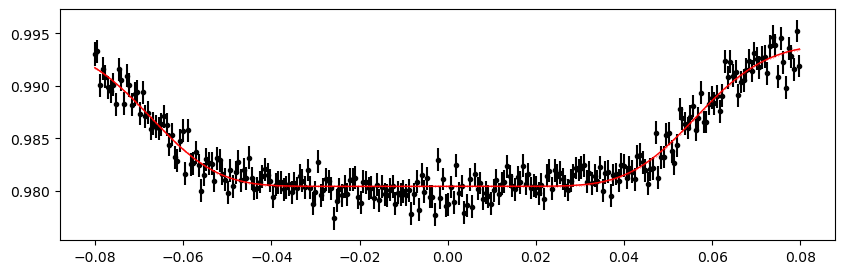

59434.982844636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 281.18it/s]


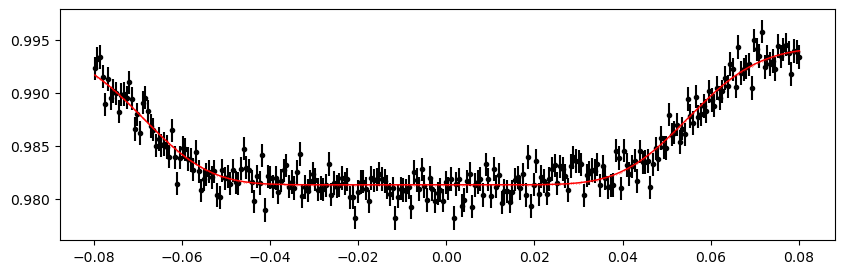

59437.285214636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.82it/s]


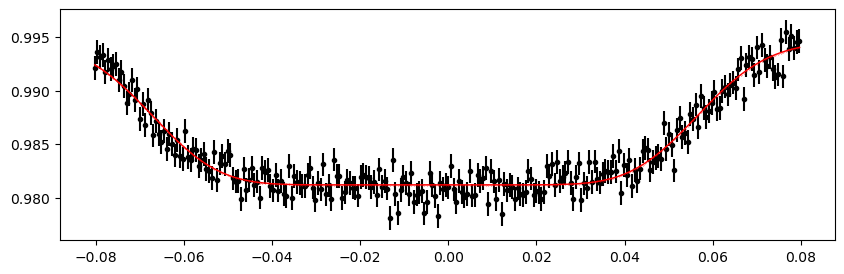

59439.587584636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.89it/s]


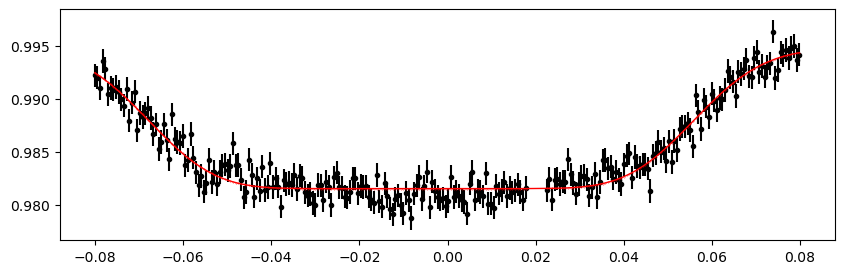

59441.889954636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.70it/s]


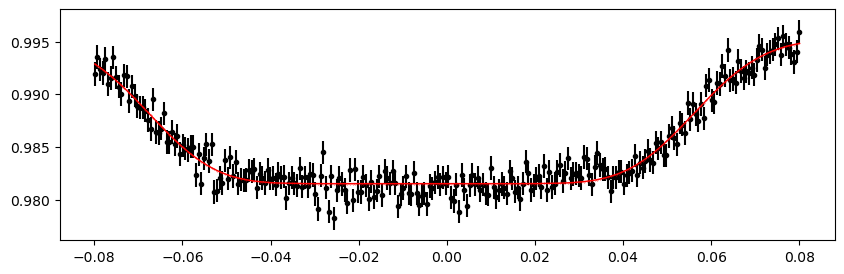

59444.192324636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.46it/s]


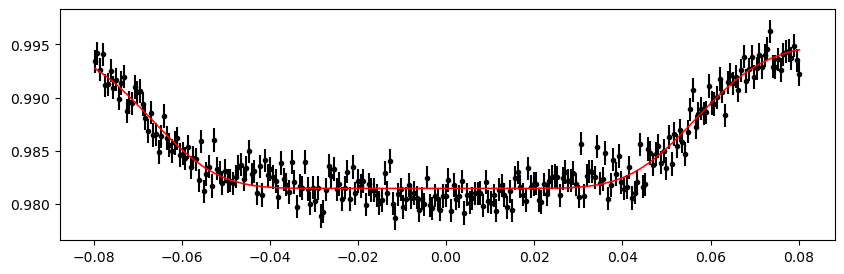

59743.500424636004 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.94it/s]


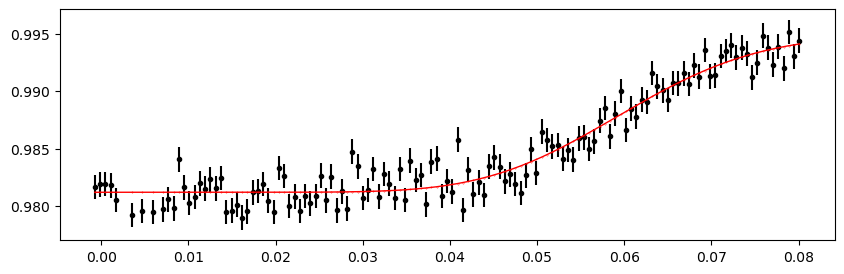

59745.802794636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.85it/s]


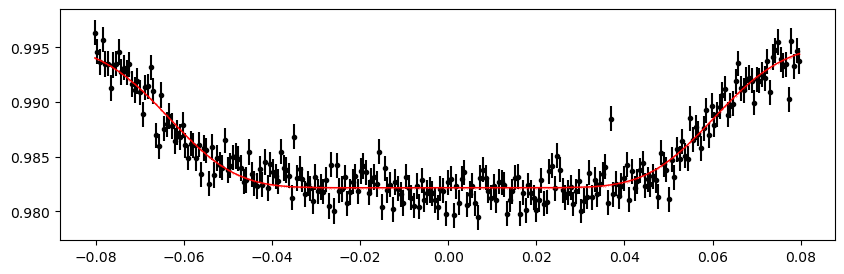

59748.105164636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.50it/s]


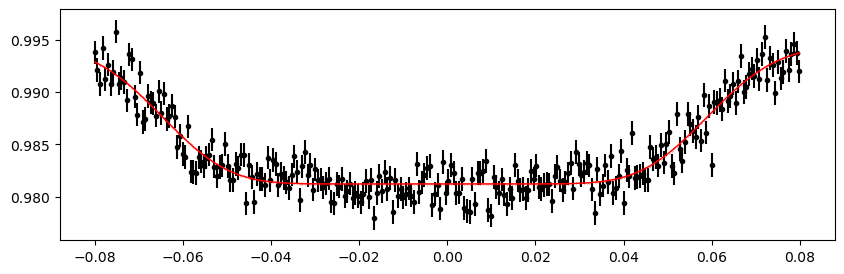

59750.407534636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.35it/s]


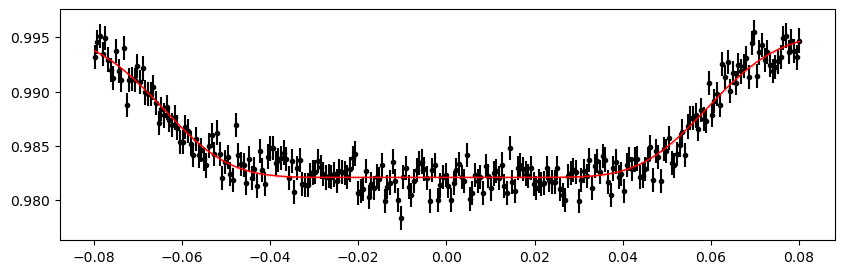

59752.709904636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 280.07it/s]


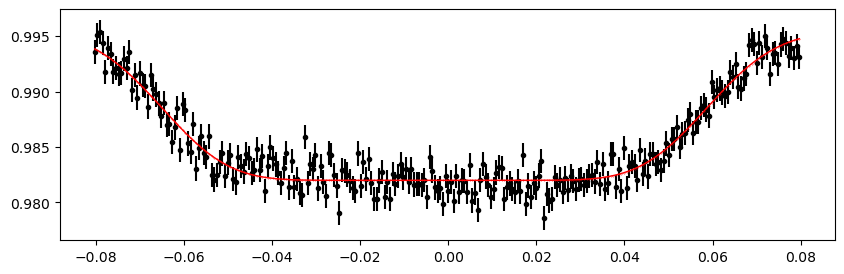

59755.012274636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.94it/s]


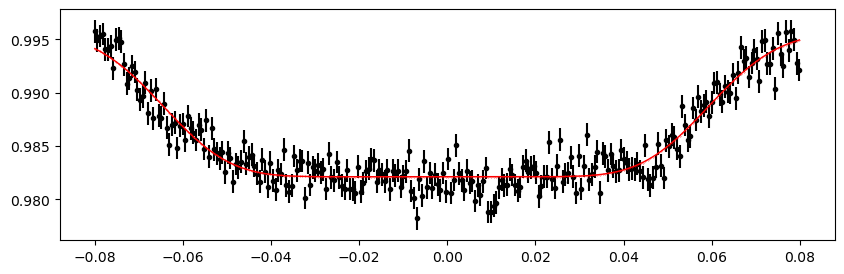

59757.314644636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.37it/s]


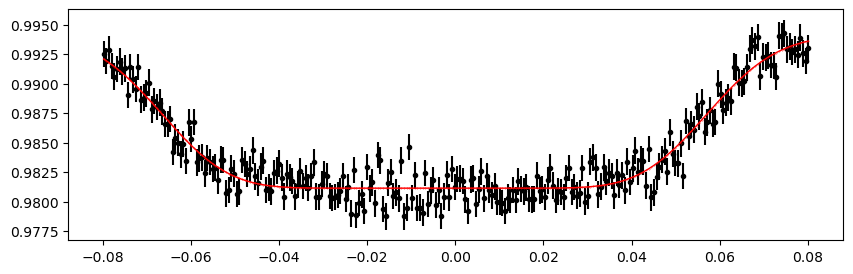

59759.617014636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.02it/s]


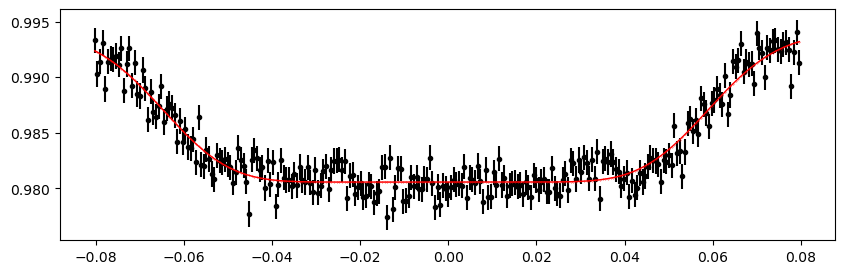

59761.919384636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.27it/s]


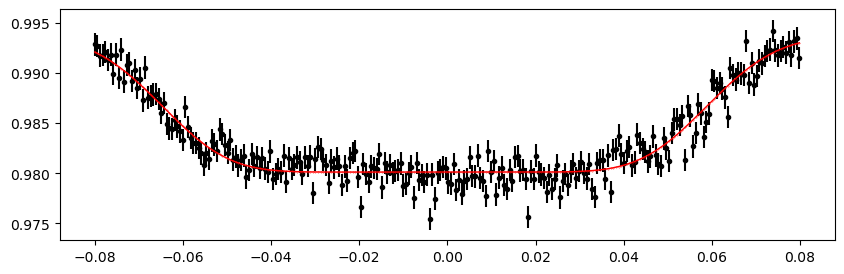

59764.221754636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.80it/s]


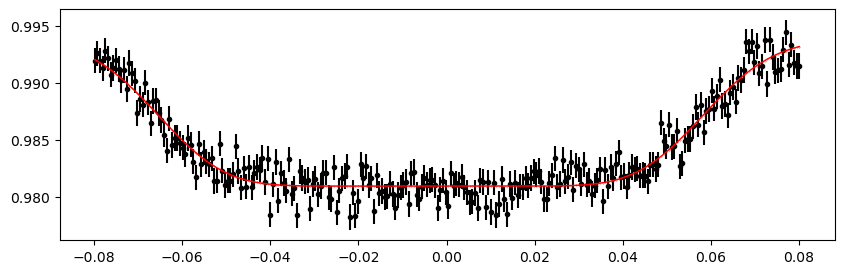

59766.524124636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.87it/s]


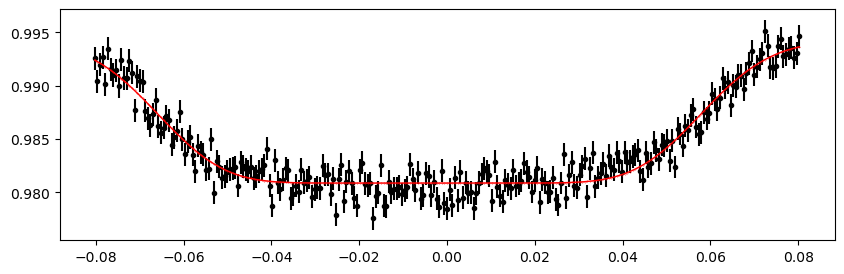

59771.128864636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.44it/s]


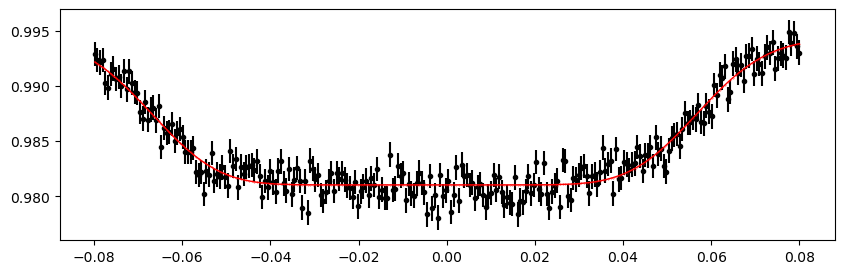

59773.431234636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.75it/s]


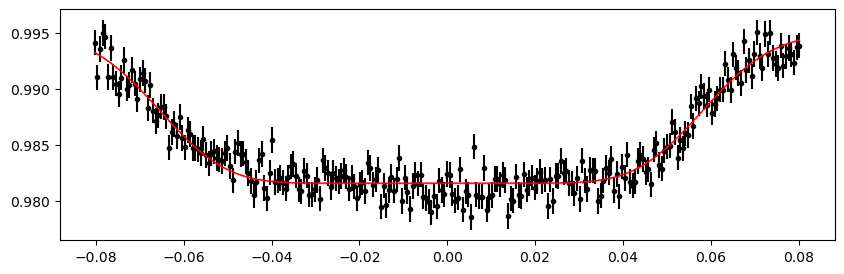

59775.733604636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.12it/s]


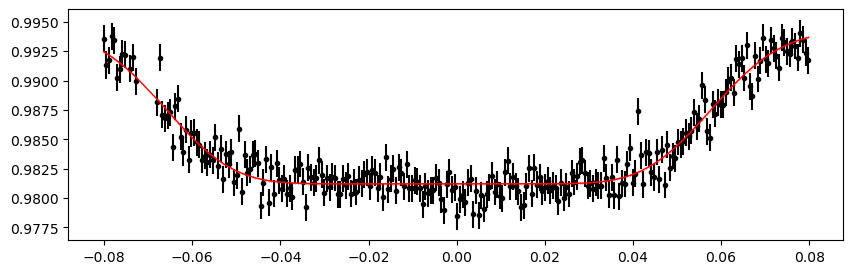

59778.035974636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.26it/s]


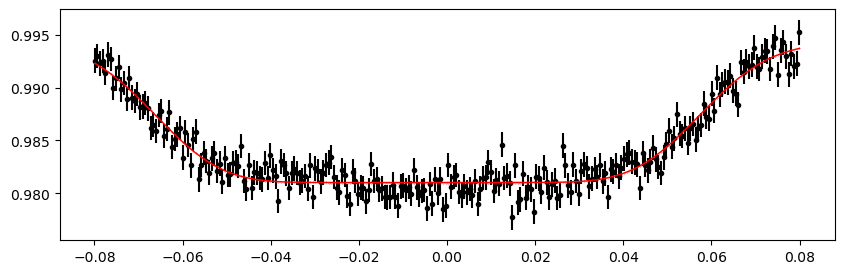

59780.338344636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.91it/s]


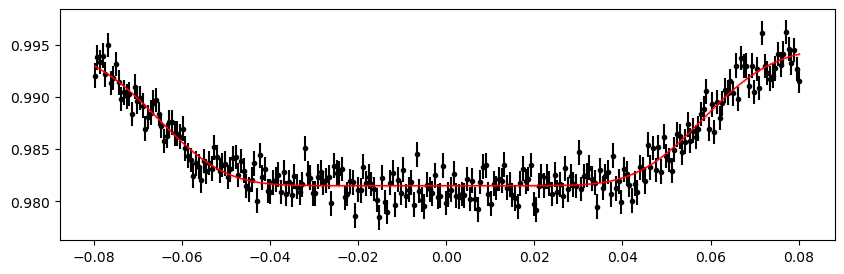

59784.943084636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.26it/s]


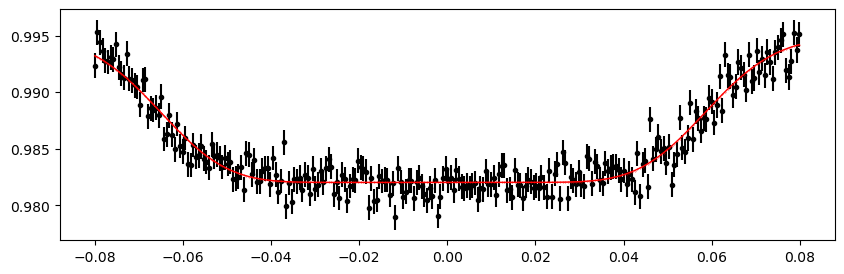

59787.245454636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.73it/s]


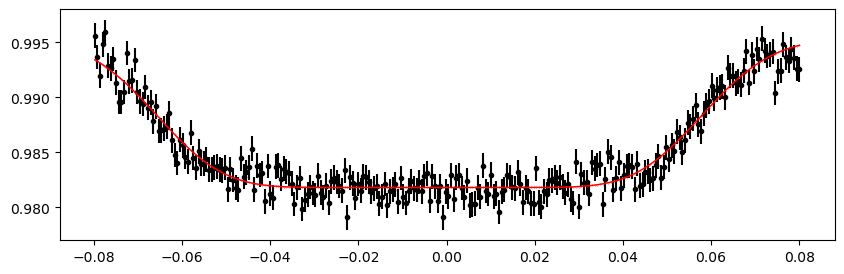

59789.547824636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.80it/s]


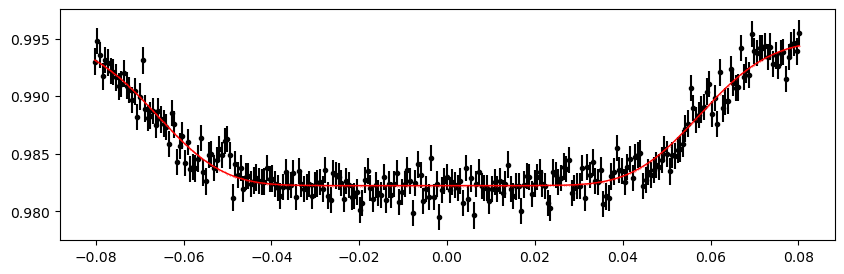

59791.850194636 0.9946783503313517 -0.013320028481656317 -0.3078815391328813


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 281.42it/s]


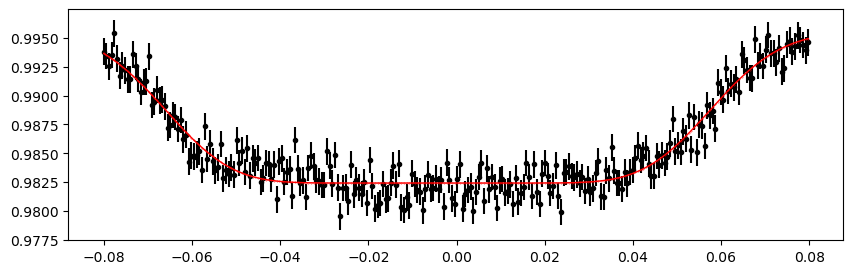

In [41]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=12,  # Kepler 30-min cadene data requires a lower min_number_data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# -----

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=12,  # Kepler 30-min cadene data requires a lower min_number_data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

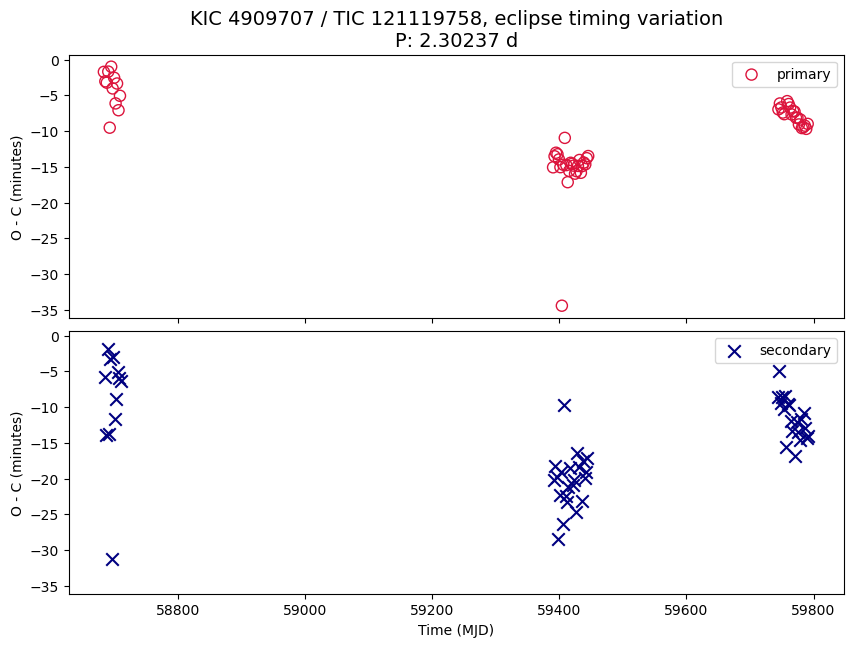

In [54]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True, sharey=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### O-C Plot, Zoom In

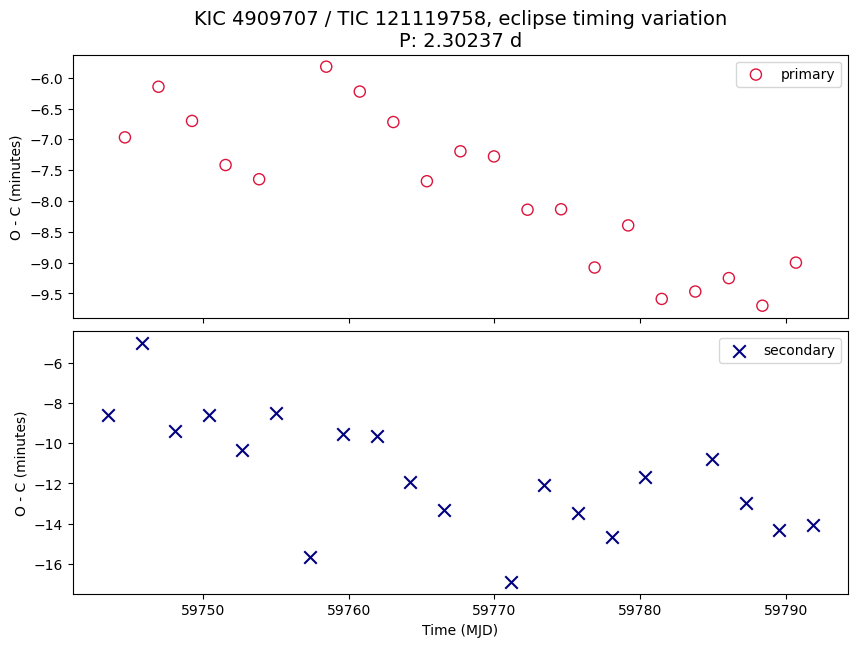

In [61]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] > 59700]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] > 59700]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


## Compare with ETV in Kepler data

- the downward slope in Kepler ETV is comparable to the TESS data around MJD 59700 at the end

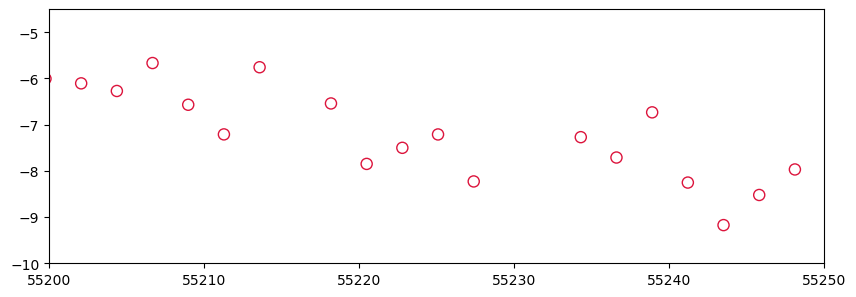

In [63]:
def plot_kepler_etv():
    # plot primary eclipses for now
    
    df_p = pd.read_csv("etv_out/tic121119758_etv_primary_Kepler.csv")
    df_p['midpoint'] = df_p['epoch'] + (df_p['t0']*period)
    df_p['shift_mins'] = df_p['t0']*period*24*60
    df_p['std_mins'] = df_p['stdv_t0']*period*24*60

    ax = plt.figure(figsize=(10,  3.3)).gca()
    ax.scatter(df_p['epoch'], df_p['shift_mins'], 
                 marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
    ax.set_xlim(55200, 55250)
    ax.set_ylim(-10, -4.5)

plot_kepler_etv();

## make a periodogram 

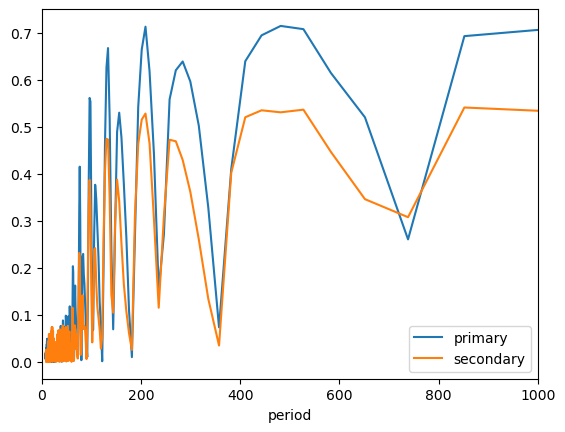

In [59]:
# TESS data roughly has a peak of ~500 days. The period found in Kepler data.
# it's understandably nosier

frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


## Results Summary

In [58]:
# FILL-IN the ETV results / comments
has_etv = "Practice"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "Reproducing Kepler ETV in 2013ApJ (TESS data). The limited TESS data  sesm to agree with Kepler data"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                     121119758
has_etv                                                                                                  Practice
comments     Reproducing Kepler ETV in 2013ApJ (TESS data). The limited TESS data  sesm to agree with Kepler data
period                                                                                                    2.30237
depth_pct_p                                                                                                  3.78
depth_pct_s                                                                                                  1.33
epoch_p                                                                                              58680.950223
epoch_s                                                                                              58682.107855
num_sectors                                                                                                     5
time_span                                                                                                 1112.77
time_start                                                                                               58682.86
time_end                                                                                                 59795.63


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
121119758,Practice,Reproducing Kepler ETV in 2013ApJ (TESS data). The limited TESS data  sesm to agree with Kepler data,2.30237,3.78,1.33,58680.950223,58682.107854636,5,1112.77,58682.86,59795.63

